<a href="https://colab.research.google.com/github/emivlp/pyspark_spark_sql/blob/main/amazon_sentiment_analysis_spark_databricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimiento con Spark ML en Azure Databricks
## Aplicación de un modelo entrenado para predecir en tiempo real
- En este notebook desarrollaremos un modelo de análisis de sentimiento a partir de opiniones de productos (en este caso, del dataset de Amazon para la categoría Sports and Outdoors). Utilizaremos técnicas de aprendizaje supervisado, específicamente regresión logística, para clasificar las opiniones en dos clases: **positiva y negativa**.

El flujo se basará en las siguientes etapas:

- **Carga y preprocesamiento de datos:** Importación del dataset, eliminación de opiniones neutrales y conversión de las valoraciones numéricas en una etiqueta binaria.
- **Muestreo estratificado:** Para equilibrar el dataset, se aplicará una técnica de submuestreo a la clase mayoritaria.
- **Ingeniería de variables:** Transformaremos el texto mediante tokenización, eliminación de palabras vacías y vectorización (CountVectorizer e IDF).
- **Construcción del Pipeline de ML:** Encadenaremos todas las transformaciones junto con un estimador (regresión logística) en un único pipeline.
- **Entrenamiento y análisis del modelo:** Entrenaremos el pipeline, extraeremos los coeficientes del modelo y determinaremos cuáles son las palabras que más influyen en la predicción del sentimiento.
- **Guardado y carga del modelo:** Para facilitar su reutilización en producción (por ejemplo, en aplicaciones en tiempo real) se guardará y posteriormente se cargará el pipeline.

Nota: En este notebook no se ha implementado la integración con Kafka para el streaming; este aspecto se puede abordar en futuras fases del trabajo.


## Aprendizaje supervisado: un problema de clasificación

Los algoritmos de aprendizaje supervisado utilizan datos etiquetados en los que tanto la entrada como el resultado objetivo (*etiqueta*), se proporcionan al algoritmo. El aprendizaje supervisado también se denomina modelado predictivo o análisis predictivo, porque crea un modelo que es capaz de realizar predicciones.

Un algoritmo de clasificación toma un conjunto de datos con etiquetas conocidas y características predeterminadas, y aprende cómo etiquetar nuevos registros en función de esa información. Las características definen a cada individuo (cada registro, fila de nuestros datos, también llamado *ejemplo*). La etiqueta es la salida que corresponde con esas características.

Veamos un ejemplo de clasificación de texto.
* ¿Qué estamos tratando de predecir?
  * Si una revisión de producto es positiva o negativa.
  * Retrasada es la etiqueta: 1 para positivo 0 para negativo
* ¿Cuáles son las propiedades que puede utilizar para hacer predicciones?
  * Las palabras del texto de revisión se utilizan como características para descubrir similitudes y categorizar el sentimiento del texto del cliente como positivo o negativo.

### Regresión logística

La regresión logística es un método popular para predecir una respuesta binaria. Es un caso especial de modelos lineales generalizados que predice la probabilidad de que la clase asociada a un ejemplo sea una de las clases, o bien la otra (suele usarse casi siempre en problemas donde los registros pertenecen a una de entre dos clases posibles). La regresión logística mide la relación entre la "etiqueta" ***Y*** y las "características" ***X*** a través la estimación de probabilidades mediante una función logística. El modelo predice una probabilidad que se utiliza para predecir la clase a la que pertenece ese ejemplo.

### Dataset de opiniones de Amazon

Se puede descargar desde <a target="_blank" href="http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz">aquí</a>

## **Introducción**

El propósito de este análisis es desarrollar un sistema de análisis de sentimiento basado en opiniones de clientes de Amazon. Cada comentario de producto se analiza para determinar si expresa un sentimiento positivo o negativo. Para ello, se ha implementado un pipeline de Spark ML que procesa y transforma los datos, entrena un modelo de regresión logística y extrae insights sobre la importancia de las palabras que influyen en la predicción del sentimiento.

Este trabajo permite:

- Automatizar el análisis de grandes volúmenes de opiniones.
- Evaluar el rendimiento del modelo utilizando un conjunto de datos de test.
- Visualizar resultados que faciliten la interpretación y el ajuste del modelo.
- Establecer una base para futuras implementaciones en tiempo real (por ejemplo, utilizando Kafka).

# **Carga y Preprocesamiento de Datos**
- En este primer bloque se descarga el dataset, se descomprime y se carga en un DataFrame de Spark. Además, se combina el resumen y el texto de la opinión para formar una única columna que usaremos en la transformación.
#### Descargamos el dataset, lo movemos a DBFS y de ahí lo copiamos a ADLS.


In [ ]:
# Descarga y descompresión (ejecutar en un entorno que permita llamadas al sistema)
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz
!gunzip reviews_Sports_and_Outdoors_5.json.gz

--2025-02-10 23:25:30--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68275834 (65M) [application/x-gzip]
Saving to: ‘reviews_Sports_and_Outdoors_5.json.gz’

reviews_Sports_and_ 100%[===================>]  65.11M  10.5MB/s    in 11s     

2025-02-10 23:25:43 (5.79 MB/s) - ‘reviews_Sports_and_Outdoors_5.json.gz’ saved [68275834/68275834]



In [ ]:
# Copia del archivo a ADLS o al contenedor de blobs (Azure Databricks o integración en Amazon)
spark.conf.set("fs.azure.account.key.masterelv001sta.blob.core.windows.net", "your key here")


In [ ]:
!mv reviews_Sports_and_Outdoors_5.json /dbfs/FileStore/

In [ ]:
display(dbutils.fs.ls("dbfs:/FileStore/"))


path,name,size,modificationTime
dbfs:/FileStore/_checkpoints/,_checkpoints/,0,1739214630000
dbfs:/FileStore/client.properties,client.properties,156,1739223792000
dbfs:/FileStore/reviews_Sports_and_Outdoors_5.json,reviews_Sports_and_Outdoors_5.json,208074896,1739229959000
dbfs:/FileStore/tables/,tables/,0,1717236420000


In [ ]:
dbutils.fs.cp("dbfs:/FileStore/reviews_Sports_and_Outdoors_5.json",
              "wasbs://datos@masterelv001sta.blob.core.windows.net/reviews_Sports_and_Outdoors_5.json")


True

### Preprocesamiento y entrenamiento del modelo

Tenemos un conjunto de datos formado por textos breves escritos por clientes de Amazon al recibir su compra, en los cuales cada cliente expresa su opinión sobre el producto adquirido. Cada registro (cada fila del dataset) representa la opinión frente a algún producto. El texto tiene, por un lado, una columna en la que el cliente da un titular o resumen a su revisión, y por otro, una columna con un texto más largo donde expresa el detalle.

El dataset se encuentra en formato JSON-line en el que cada línea es un JSON completo, como el del siguiente ejemplo:

`{"reviewerID": "A1PUWI9RTQV19S", "asin": "B003Y5C132", "reviewerName": "kris", "helpful": [0, 1], "reviewText": "A little small in hind sight, but I did order a .30 cal box. Good condition, and keeps my ammo organized.", "overall": 5.0, "summary": "Nice ammo can", "unixReviewTime": 1384905600, "reviewTime": "11 20, 2013"}`

que, como vemos, sigue el siguiente esquema:

* **reviewerID** - identificador del cliente, p.ej. A2SUAM1J3GNN3B
* **asin** - identificador del producto, p.ej. 0000013714
* **reviewerName** - nombre del cliente
* **helpful** - valoración del grado de utilidad de esta opinión, expresado como un número real entre 0 y 1, p.ej. 2/3
* **reviewText** - texto de la opinión
* **overall** - valoración que da el cliente al producto, entre 1 y 5
* **summary** - resumen de la revisión
* **unixReviewTime** - instante en el que se creó esta opinión (expresado como unix time)
* **reviewTime** - instante en el que se creó esta opinión (formato en crudo)

In [ ]:
from pyspark.sql import functions as F

# Lectura del dataset en Spark
rawDF = spark.read\
           .option("inferSchema", "true")\
           .json("wasbs://datos@masterelv001sta.blob.core.windows.net/reviews_Sports_and_Outdoors_5.json")

# Combinamos "summary" y "reviewText" en una única columna "reviewTS" para simplificar el análisis
df = rawDF.withColumn("reviewTS",
                      F.concat(F.col("summary"), F.lit(" "), F.col("reviewText")))\
          .drop("helpful", "reviewerID", "reviewerName", "reviewTime")

# Visualización de las primeras filas para confirmar la carga de datos
df.limit(5).display()

# Mostrar el esquema para verificar que la columna 'reviewTS' se creó correctamente
df.printSchema()

asin,overall,reviewText,summary,unixReviewTime,reviewTS
1881509818,5.0,"This came in on time and I am veru happy with it, I haved used it already and it makes taking out the pins in my glock 32 very easy",Woks very good,1390694400,"Woks very good This came in on time and I am veru happy with it, I haved used it already and it makes taking out the pins in my glock 32 very easy"
1881509818,5.0,"I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I've since lost it and had needed another. Since I've used Ghost products prior, and know that they are reliable, I had decided to order this one. Sure enough, this is just as good as a factory tool.",Works as well as the factory tool,1328140800,"Works as well as the factory tool I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I've since lost it and had needed another. Since I've used Ghost products prior, and know that they are reliable, I had decided to order this one. Sure enough, this is just as good as a factory tool."
1881509818,4.0,"If you don't have a 3/32 punch or would like to have one in your Glock bag, this is okay. The butt end of it is handy for pushing pins back in place. If you already have a 3/32 punch and don't need another, don't both with this one.","It's a punch, that's all.",1330387200,"It's a punch, that's all. If you don't have a 3/32 punch or would like to have one in your Glock bag, this is okay. The butt end of it is handy for pushing pins back in place. If you already have a 3/32 punch and don't need another, don't both with this one."
1881509818,4.0,"This works no better than any 3/32 punch you would find at the hardware store. Actually, I think you would be better with a regular punch as it has more to hold on to.",It's a punch with a Glock logo.,1328400000,"It's a punch with a Glock logo. This works no better than any 3/32 punch you would find at the hardware store. Actually, I think you would be better with a regular punch as it has more to hold on to."
1881509818,4.0,"I purchased this thinking maybe I need a special tool to easily pop off my base plates for my magazines, but it does the same as a regular punch tool. Glock mags are a pain to get the base plates off. The tool does not really make a difference.","Ok,tool does what a regular punch does.",1366675200,"Ok,tool does what a regular punch does. I purchased this thinking maybe I need a special tool to easily pop off my base plates for my magazines, but it does the same as a regular punch tool. Glock mags are a pain to get the base plates off. The tool does not really make a difference."


root
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- reviewTS: string (nullable = true)



# **Eliminación de Opiniones Neutrales y Conversión de Etiquetas**

  Para simplificar la clasificación, eliminamos las opiniones con valoración 3 (neutrales). A continuación, transformamos la valoración numérica en una etiqueta binaria:

- Valoraciones 1 y 2 → **Negativo (0)**
- Valoraciones 4 y 5 → **Positivo (1)**

## Conversión de la valoración numérica en una etiqueta binaria

## **Conversión a Etiqueta Binaria con Binarizer**

Utilizamos el transformador Binarizer de Spark para crear la columna label.

Vamos a crear, a partir de la columna `overall` que contiene la valoración numérica, una nueva columna binaria llamada `label` que será la que utilice nuestros algoritmo predictivo. Para ello utilizaremos un `Binarizer` de Spark, fijando el umbral en 3.0 (que nunca se da en nuestros datos porque ya lo habíamos quitado). Todo valor por debajo de este umbral será considerado como 0.0 y todo valor por encima será convertido en 1.0. La columna original `overall` no se modifica.

In [ ]:
from pyspark.ml.feature import Binarizer

# Eliminamos las opiniones con valor 3 (neutrales)
no_neutral_df = df.filter("overall != 3")
no_neutral_df.show()

# Convertimos la columna 'overall' en una etiqueta binaria:
# - Valores 1 y 2 serán 0 (negativo)
# - Valores 4 y 5 serán 1 (positivo)
binarizer = Binarizer(inputCol="overall", outputCol="label", threshold=3.0)
binary_target_df = binarizer.transform(no_neutral_df)

# Visualizamos la conversión agrupando por 'overall' y 'label'
binary_target_df.groupBy("overall", "label").count().show()


+----------+-------+--------------------+--------------------+--------------+--------------------+
|      asin|overall|          reviewText|             summary|unixReviewTime|            reviewTS|
+----------+-------+--------------------+--------------------+--------------+--------------------+
|1881509818|    5.0|This came in on t...|      Woks very good|    1390694400|Woks very good Th...|
|1881509818|    5.0|I had a factory G...|Works as well as ...|    1328140800|Works as well as ...|
|1881509818|    4.0|If you don't have...|It's a punch, tha...|    1330387200|It's a punch, tha...|
|1881509818|    4.0|This works no bet...|It's a punch with...|    1328400000|It's a punch with...|
|1881509818|    4.0|I purchased this ...|Ok,tool does what...|    1366675200|Ok,tool does what...|
|1881509818|    5.0|Needed this tool ...|Glock punch tool ...|    1351814400|Glock punch tool ...|
|1881509818|    5.0|If u don't have i...|          Great tool|    1402358400|Great tool If u d...|
|209486924

La función `describe()` nos da estadísticas de resumen acerca de una o varias columnas numéricas.

In [ ]:
no_neutral_df.describe("overall").show()

+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|            272266|
|   mean|  4.51664548639933|
| stddev|0.9344777791100682|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



# **Muestreo Estratificado para Balancear el Dataset**

Dado que la clase positiva está sobrerrepresentada, se procede a realizar un muestreo estratificado que mantiene todos los ejemplos de la clase negativa y un 10% de la clase positiva.

Como suele ser habitual en los problemas de clasificación binaria, existen muchos más ejemplos pertenecientes a una clase (en este caso la clase positiva) que a otra. Para que el modelo también sea sensible a ejemplos de la clase negativa, es conveniente tratar de equilibrar la proporción de ejemplos de cada clase presentes en nuestro conjunto de datos. Hay varias estrategias para conseguir esto. Aquí optamos por la más simple (y a la vez, la menos recomendable en problemas reales) que es eliminar ejemplos de la clase mayoritaria.

Utilizamos la función `sampleBy()` indicando la fracción de ejemplos de cada clase que queremos mantener. En este caso queremos mantener todos los ejemplos de la clase negativa (que son minoría), pero tan sólo queremos mantener el 10 % de los ejemplos de la clase mayoritaria. Si mostramos la cantidad de ejemplos en el DataFrame resultante de este muestreo, vemos que están más equilibrados aunque aún sigue ligeramente inclinado hacia la clase 1.0.

In [ ]:
# Debido a la desproporción de clases, mantenemos el 100% de la clase minoritaria (0)
# y solo el 10% de la clase mayoritaria (1)
fractions = {1.0: 0.1, 0.0: 1.0}
balanced_df = binary_target_df.stat.sampleBy("label", fractions, seed=36)
balanced_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|19249|
|  1.0|25317|
+-----+-----+



Para poder saber cómo de bien funcionará el modelo entrenado en datos nuevos nunca vistos, vamos a dividir el conjunto de datos en subconjuntos de entrenamiento y de test. El conjunto de test se utilizará una sola vez, al final, cuando ya tengamos decidido y entrenado el modelo de predicción. El objetivo del conjunto de test será calcular una métrica que estime la bondad del modelo cuando sea puesto en producción y empiece a predecir datos sobre los que realmente no se conoce su etiqueta.

#### **Usamos el 80 % de nuestros datos para entrenar, y el 20 % los dejamos fuera porque serán el conjunto de test.**

In [ ]:
# Dividimos el dataset en 80% para entrenamiento y 20% para test
split_seed = 5043
training_data, test_data = balanced_df.randomSplit([0.8, 0.2], split_seed)

# Cacheamos los datos de entrenamiento para mejorar el rendimiento
training_data.cache()
training_data.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|  0.0|15410|
|  1.0|20232|
+-----+-----+



## Ingeniería de Variables y Construcción del Pipeline

Para que las características sean utilizadas por un algoritmo de aprendizaje automático, es fundamental transformar los textos (o cualquier dato no estructurado) en vectores numéricos que representen el valor de cada característica. Los textos, en su forma cruda, no pueden ser interpretados directamente por los algoritmos, por lo que se deben procesar y convertir en una representación adecuada.

Spark ML nos proporciona un conjunto uniforme de API de alto nivel basadas en DataFrames que facilitan este proceso. Utilizaremos un ML Pipeline para encadenar múltiples transformadores y estimadores, lo que permite definir un flujo de trabajo completo, desde la transformación de los datos hasta el entrenamiento del modelo y su aplicación a nuevos datos.

### Componentes del Pipeline

- **Transformadores:**
  - **Tokenización:**  
    Utilizamos `RegexTokenizer` para dividir el texto en palabras (tokens). Cada documento se transforma en un vector de cadenas, lo que facilita el análisis de las palabras contenidas.
  - **Eliminación de Stop Words:**  
    Con `StopWordsRemover` se eliminan las palabras vacías o de baja relevancia (por ejemplo, artículos y preposiciones) que no aportan significado al análisis.
  - **Vectorización:**  
    Se emplea `CountVectorizer` para contar las ocurrencias de cada palabra en el corpus, limitando la representación a las 20,000 palabras más relevantes. Este recuento se utiliza para formar un vector numérico.
  - **TF-IDF:**  
    A partir del vector generado por el `CountVectorizer`, se calcula el valor TF-IDF (Term Frequency-Inverse Document Frequency) mediante el transformador `IDF`. Esto ajusta los valores numéricos para reflejar la importancia relativa de cada término en el corpus.

- **Estimador:**
  - **Regresión Logística:**  
    Una vez que los textos se han transformado en vectores de características, se aplica un modelo de Regresión Logística para clasificar los ejemplos en dos categorías (por ejemplo, sentimiento positivo o negativo). El modelo entrenado se comporta como un transformador, permitiendo la aplicación del mismo conjunto de transformaciones a nuevos datos.

- **Pipeline:**
  - El **Pipeline de Spark ML** encadena todos los transformadores y el estimador en un único flujo. Esto facilita tanto el entrenamiento del modelo como su aplicación durante la inferencia, garantizando consistencia entre ambos procesos. Además, se puede incluir un evaluador para medir la bondad del modelo mediante métricas específicas (precisión, recall, F1, AUC, etc.).

### Resumen del Proceso en el Pipeline

1. **Tokenización:**  
   Se separa el texto en palabras, transformando cada documento en un vector de tokens.
2. **Eliminación de Stop Words:**  
   Se eliminan las palabras vacías para reducir el ruido y enfocarse en términos de mayor relevancia.
3. **Vectorización y Cálculo de TF-IDF:**  
   - **CountVectorizer:** Convierte los tokens en un vector numérico basado en la frecuencia de cada palabra, limitado a las 20,000 palabras más importantes.  
   - **IDF:** Transforma los recuentos en valores TF-IDF, ponderando la importancia de cada término según su frecuencia en el corpus.
4. **Estimador – Regresión Logística:**  
   Se entrena un modelo que aprende a clasificar los ejemplos en función de los vectores de características resultantes.
5. **Construcción del Pipeline:**  
   Todas las etapas anteriores se integran en un único pipeline, lo que permite entrenar el modelo y aplicar las mismas transformaciones a nuevos datos de manera consistente.

Este enfoque integral facilita la transformación y el modelado de datos textuales, garantizando reproducibilidad y escalabilidad en aplicaciones de análisis de sentimiento.

Empezaremos con las siguientes etapas de ingeniería de variables:

* Primero utilizamos un `RegexTokenizer` para separar cada texto en palabras. Esto transforma cada texto en un vector de strings con las palabras. Para más detalles: http://spark.apache.org/docs/latest/ml-features.html#tokenizer
* Después aplicaremos un `StopWordsRemover` para eliminar de cada vector de palabras aquellas sin significado, como artículos, preposiciones, etc. Para más detalles: http://spark.apache.org/docs/latest/ml-features.html#stopwordsremover


In [ ]:
# Importar transformadores para el procesamiento de texto
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression

# Tokenización: se divide el texto en palabras
tokenizer = RegexTokenizer(inputCol="reviewTS", outputCol="reviewTokensUf", pattern="\\s+|[,.()\"]")

# Eliminación de stop words: se remueven palabras sin significado
remover = StopWordsRemover(inputCol="reviewTokensUf", outputCol="reviewTokens") \
            .setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

# Vectorización: CountVectorizer para contar la frecuencia de palabras (máximo 20,000 términos)
count_vectorizer = CountVectorizer(inputCol="reviewTokens", outputCol="cv") \
                    .setVocabSize(20000) \
                    .setMinDF(4)

# Cálculo de TF-IDF: se transforma el vector de frecuencias en valores TF-IDF
idf = IDF(inputCol="cv", outputCol="features")

# Estimador: Regresión Logística para clasificar las opiniones (0 o 1)
logisticRegression = LogisticRegression(featuresCol="features", labelCol="label") \
                        .setMaxIter(100) \
                        .setRegParam(0.02) \
                        .setElasticNetParam(0.3)

Utilizaremos el siguiente método para convertir vectores de palabras de un texto en vectores numéricos, utilizables por un algoritmo predictivo.

**De la documentación oficial de Spark**:

TF-IDF es un método de vectorización de características ampliamente utilizado en la minería de texto para reflejar la importancia de un término para un documento en el corpus. Si denotamos a un término (palabra) como *t*, un documento como *d* y el corpus como *D*, entonces:

* La Frecuencia de un término **TF(*t*, *d*)** es el número de veces que el término *t* aparece en el documento *d*
* La frecuencia en el documento **DF(*t*, *D*)** es el número de documentos que contienen el término *t*.

Si solo usamos la frecuencia de los términos para medir la importancia, es muy fácil sobreenfatizar erróneamente los términos que aparecen con mucha frecuencia pero que contienen poca información sobre el documento, p. Ej. la palabra *fútbol* en un corpus compuesto por biografías de futbolistas. Si un término aparece con mucha frecuencia en el corpus, significa que no contiene información especial sobre un documento en particular.

* La *frecuencia inversa de los documentos* **IDF(*t*, *D*)** es una medida numérica de cuánta información proporciona un término:

$$ IDF (t, D) = \frac{log | D | +1} {DF (t, D) +1} $$

donde | D | es el número total de documentos del corpus. Dado que se usa logaritmo, si un término aparece en todos los documentos, su valor IDF se convierte en 0. Tenga en cuenta que se aplica un término de suavizado para evitar dividir por cero para los términos fuera del corpus.

La medida TF-IDF es simplemente el producto de TF e IDF:
$$ TFIDF (t, d, D) = TF (t, d) ⋅ IDF (t, D) $$

Hay varias variantes en la definición de TF y de IDF. En Spark ML, están separados para que sean flexibles y poder combinarlos de varias maneras.

* `CountVectorizer()` cuenta las ocurrencias totales de cada palabra en todo el corpus de textos, y se queda con las N más relevantes, siendo N un parámetro especificado por el usuario (en nuestro caso, N = 20000). Tras esto, en cada texto contará el número de apariciones de cada una de esas N palabras seleccionadas. Por tanto, cada texto vendrá representado por un vector numérico de longitud 20000, y nuestro problema tendrá 20000 variables.

* `HashingTF()` es similar, pero cada posición no se asocia a una sola palabra sino que puede estar compartida por más de una. El usuario especifica también la dimensión N de los vectores obtenidos (se recomienda que sea una potencia de 2 debido a cómo actúa esta técnica). A grandes rasgos, cada palabra se codifica mediante un código que a su vez va a parar a una posición determinada del vector numérico que va a representar a ese texto, por lo que puede haber colisiones en algunas ocasiones, y que una posición sea utilizada para acumular las apariciones de más de una palabra diferente.

Se puede utilizar cualquiera de estas opciones, aunque no las dos simultáneamente.

## Configuración y Entrenamiento del Pipeline
- Encadenamos todas las etapas anteriores en un único Pipeline para facilitar el entrenamiento y la posterior aplicación sobre nuevos datos.

In [ ]:
from pyspark.ml import Pipeline

# Encadenamos las etapas de transformación y el estimador en un único Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, count_vectorizer, idf, logisticRegression])

# Entrenamos el pipeline usando los datos de entrenamiento
pipelineModel = pipeline.fit(training_data)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

## **Evaluación del Modelo**
- En esta sección, evaluaremos el rendimiento del modelo entrenado utilizando el conjunto de datos de test. Calcularemos métricas clave de clasificación como Accuracy, Precision, Recall y F1-Score para obtener una medida cuantitativa del rendimiento del modelo en datos no vistos durante el entrenamiento.


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Predecimos con el modelo sobre los datos de test
predictions_test = pipelineModel.transform(test_data)

# Evaluador para métricas de clasificación multiclase (aunque es clasificación binaria, es útil para Accuracy y F1)
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluador para métricas de clasificación binaria (útil para AUC - Area Under ROC Curve)
evaluator_binary = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Calculamos las métricas
accuracy = evaluator_multi.evaluate(predictions_test, {evaluator_multi.metricName: "accuracy"})
f1_score = evaluator_multi.evaluate(predictions_test, {evaluator_multi.metricName: "f1"})
precision = evaluator_multi.evaluate(predictions_test, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions_test, {evaluator_multi.metricName: "weightedRecall"})
auc = evaluator_binary.evaluate(predictions_test, {evaluator_binary.metricName: "areaUnderROC"})

print(f"Métricas en el conjunto de Test:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  F1 Score:   {f1_score:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  AUC:        {auc:.4f}")

Métricas en el conjunto de Test:
  Accuracy:   0.8647
  F1 Score:   0.8635
  Precision:  0.8663
  Recall:     0.8647
  AUC:        0.9345


# **Extracción de Insights y Análisis del Modelo**
- Una vez entrenado el modelo, se extraen los coeficientes de la regresión logística para identificar qué palabras tienen mayor impacto en la predicción del sentimiento.

- Examinamos los coeficientes de la regresión logística buscando los que son mayores en valor absoluto. Puesto que los datos de entrada son valores de TF-IDF, sus rangos son aproximadamente similares.

In [ ]:
import pandas as pd
import numpy as np

# Extraemos el vocabulario del CountVectorizer (tercera etapa del pipeline)
vocabulary = pipelineModel.stages[2].vocabulary

# Extraemos el modelo de regresión logística (última etapa del pipeline)
lrModel = pipelineModel.stages[-1]

# Convertir los coeficientes (DenseVector) a un arreglo de Numpy de floats
weights_array = np.array(lrModel.coefficients)

# Asociamos cada palabra con su coeficiente (ya convertido a float)
word_weight = list(zip(vocabulary, weights_array))

# Ordenamos de mayor a menor valor absoluto del coeficiente
word_weight.sort(key=lambda pair: abs(pair[1]), reverse=True)

# Convertimos la lista a un DataFrame para visualizar los 20 términos más influyentes
word_weight_df = pd.DataFrame(word_weight, columns=["word", "weight"])[0:20]
word_weight_df



,word,weight
0,great,0.577747
1,returned,-0.373278
2,poor,-0.332330
3,perfect,0.316101
4,waste,-0.280948
5,useless,-0.279297
6,broke,-0.270670
7,junk,-0.262432
8,return,-0.258069
9,easy,0.256281


**Esta tabla permite identificar qué palabras se asocian de forma positiva o negativa con las opiniones de los clientes.**

### **Histogramas: Distribución de la columna overall**
- Antes y después de eliminar opiniones neutrales

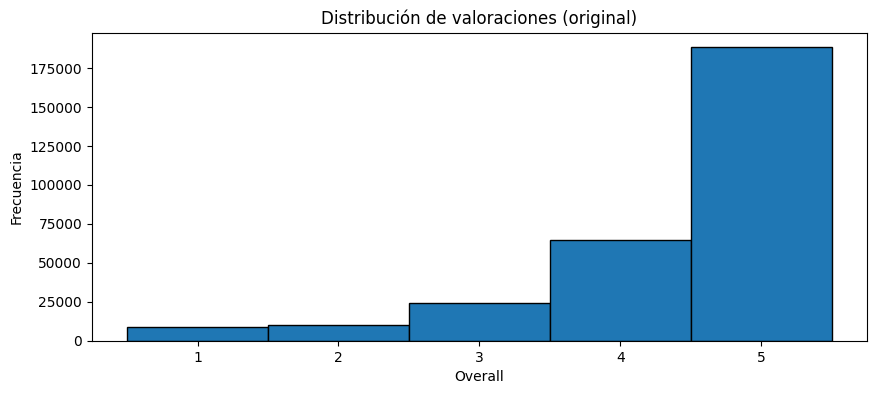

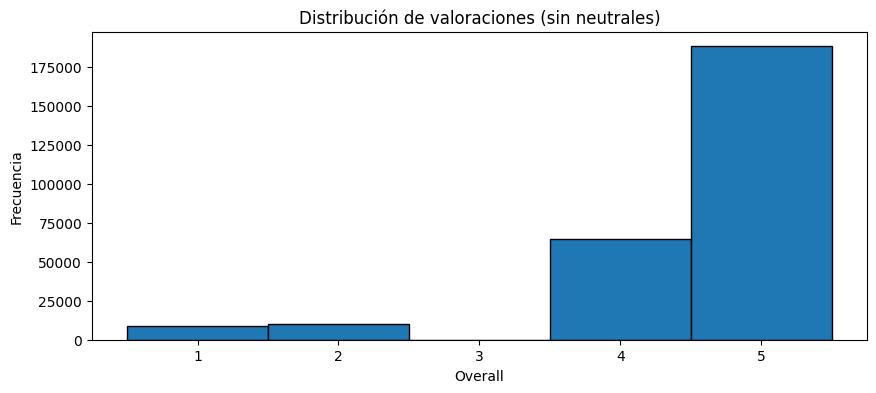

In [ ]:
import matplotlib.pyplot as plt

# Recopilar datos para el histograma (antes de filtrar opiniones neutrales)
df_overall = df.select("overall").toPandas()

plt.figure(figsize=(10, 4))
plt.hist(df_overall["overall"], bins=range(1, 7), align="left", edgecolor="black")
plt.title("Distribución de valoraciones (original)")
plt.xlabel("Overall")
plt.ylabel("Frecuencia")
plt.xticks(range(1, 6))
plt.show()

# Recopilar datos para el histograma (después de filtrar opiniones neutrales)
df_overall_filtered = no_neutral_df.select("overall").toPandas()

plt.figure(figsize=(10, 4))
plt.hist(df_overall_filtered["overall"], bins=range(1, 7), align="left", edgecolor="black")
plt.title("Distribución de valoraciones (sin neutrales)")
plt.xlabel("Overall")
plt.ylabel("Frecuencia")
plt.xticks(range(1, 6))
plt.show()


### **Gráficos de Barras: Distribución de clases antes y después del balanceo**

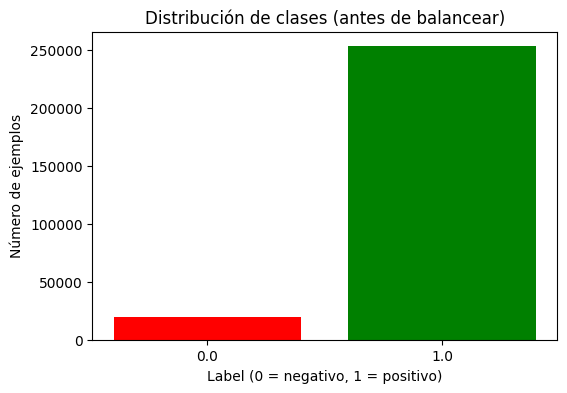

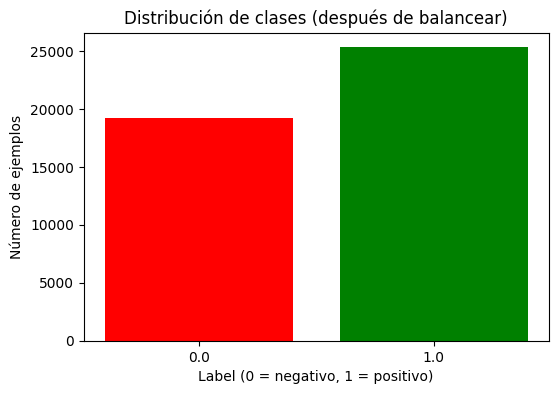

In [ ]:
# Antes del balanceo: distribución de la etiqueta binaria
df_labels = binary_target_df.groupBy("label").count().toPandas()
plt.figure(figsize=(6, 4))
plt.bar(df_labels["label"].astype(str), df_labels["count"], color=['red', 'green'])
plt.title("Distribución de clases (antes de balancear)")
plt.xlabel("Label (0 = negativo, 1 = positivo)")
plt.ylabel("Número de ejemplos")
plt.show()

# Después del balanceo: distribución de la etiqueta
df_labels_balanced = balanced_df.groupBy("label").count().toPandas()
plt.figure(figsize=(6, 4))
plt.bar(df_labels_balanced["label"].astype(str), df_labels_balanced["count"], color=['red', 'green'])
plt.title("Distribución de clases (después de balancear)")
plt.xlabel("Label (0 = negativo, 1 = positivo)")
plt.ylabel("Número de ejemplos")
plt.show()


### **Word Cloud: Importancia de palabras**

- Para generar un word cloud, necesitas instalar la librería wordcloud (si no la tienes instalada, ejecuta !pip install wordcloud).

In [ ]:
!pip install wordcloud

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


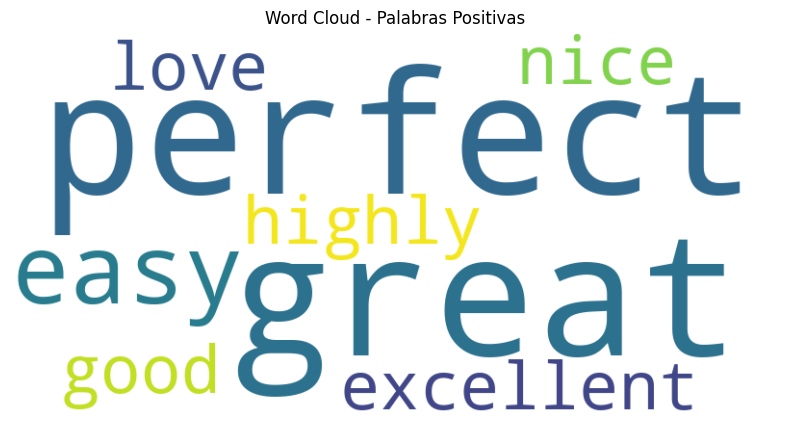

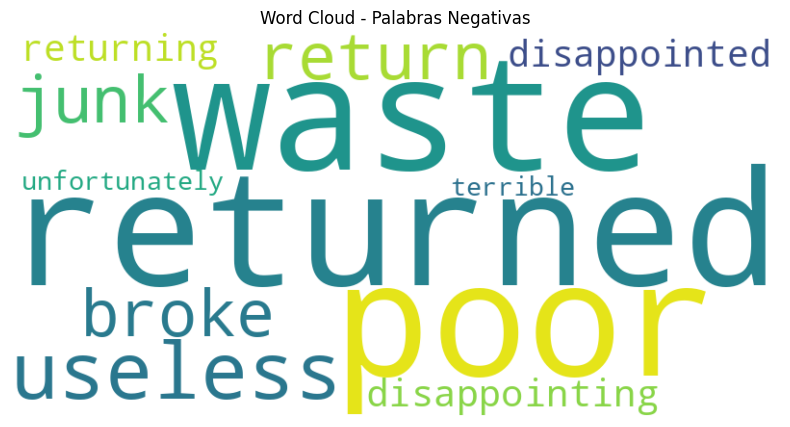

In [ ]:
from wordcloud import WordCloud

# Crear dos textos: uno para las palabras con coeficientes positivos y otro para las negativas.
# Usaremos el DataFrame `word_weight_df` obtenido de la extracción de insights.

positive_words = " ".join(word for word, weight in word_weight_df.itertuples(index=False) if weight > 0)
negative_words = " ".join(word for word, weight in word_weight_df.itertuples(index=False) if weight < 0)

# Generar el word cloud para palabras positivas
wc_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.figure(figsize=(10, 5))
plt.imshow(wc_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Palabras Positivas")
plt.show()

# Generar el word cloud para palabras negativas
wc_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)
plt.figure(figsize=(10, 5))
plt.imshow(wc_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Palabras Negativas")
plt.show()


### **Curva ROC y AUC**
Utilizando las predicciones en el conjunto de test, puedes graficar la curva ROC. Necesitamos convertir el DataFrame de Spark a Pandas para usar sklearn o matplotlib.

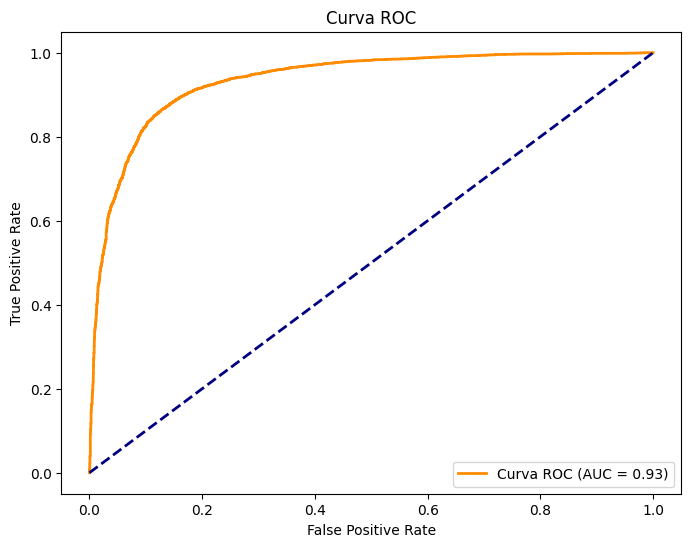

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import numpy as np
from pyspark.ml.linalg import DenseVector  # Importa DenseVector

# 1. Aplicar el modelo al conjunto de test y obtener las predicciones
predictions_test = pipelineModel.transform(test_data)

# 2. Convertir las columnas de interés a un DataFrame de Pandas
preds_pd = predictions_test.select("label", "rawPrediction").toPandas()

# 3. Extraer la probabilidad de la clase positiva.
# Se verifica si el objeto es una instancia de DenseVector y se extrae el valor en la posición 1.
preds_pd["prob_pos"] = preds_pd["rawPrediction"].apply(
    lambda x: float(x[1]) if isinstance(x, DenseVector) else float(x)
)

# 4. Calcular la curva ROC y el valor AUC usando sklearn
fpr, tpr, thresholds = roc_curve(preds_pd["label"], preds_pd["prob_pos"])
roc_auc = auc(fpr, tpr)

# 5. Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


# **Experimentación y Ajuste de Hiperparámetros**

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Definir evaluador basado en AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

# Crear una grilla de parámetros para el modelo de regresión logística
paramGrid = (ParamGridBuilder()
             .addGrid(logisticRegression.regParam, [0.01, 0.02, 0.03])
             .addGrid(logisticRegression.elasticNetParam, [0.0, 0.3, 0.6])
             .build())

# Configurar el CrossValidator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

# Entrenar el modelo usando CrossValidator
cvModel = cv.fit(training_data)
best_auc = evaluator.evaluate(cvModel.transform(test_data))
print(f"Mejor AUC obtenido con CrossValidator: {best_auc:.4f}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Mejor AUC obtenido con CrossValidator: 0.9428


In [ ]:
# Aplicar el modelo optimizado (cvModel) al conjunto de test
predictions_cv = cvModel.transform(test_data)

# Calcular Accuracy manualmente para cvModel
total_cv = predictions_cv.count()
correct_cv = predictions_cv.filter("prediction == label").count()
accuracy_cv = correct_cv / total_cv
print(f"Accuracy en el conjunto de test (cvModel): {accuracy_cv:.4f}")

# Calcular F1-Score usando MulticlassClassificationEvaluator para cvModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_cv = multiclass_evaluator.evaluate(predictions_cv)
print(f"F1-Score en el conjunto de test (cvModel): {f1_cv:.4f}")

# Evaluar AUC para cvModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_binary = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_cv = evaluator_binary.evaluate(predictions_cv)
print(f"AUC en el conjunto de test (cvModel): {auc_cv:.4f}")


Accuracy en el conjunto de test (cvModel): 0.8783
F1-Score en el conjunto de test (cvModel): 0.8777
AUC en el conjunto de test (cvModel): 0.9428


## **Guardado y Carga del Modelo**

- Para facilitar la aplicación del modelo en tiempo real (por ejemplo, integrándolo en una aplicación que realice predicciones de sentimiento en vivo), se guarda el pipeline completo. Luego, se puede cargar sin necesidad de redefinir cada uno de sus componentes.

In [ ]:
from pyspark.ml import PipelineModel

# Guardar el pipeline entrenado en DBFS
pipelineModel.write().overwrite().save("/user/sentiment_pipeline")
print("Modelo guardado en /user/sentiment_pipeline")

# Cargar el modelo (para futuras inferencias)
loadedPipelineModel = PipelineModel.load("/user/sentiment_pipeline")
print("Modelo cargado exitosamente.")


Modelo guardado en /user/sentiment_pipeline
Modelo cargado exitosamente.


## **Aplicación del Modelo a Nuevos Datos (Inferencia)**
- Se demuestra la inferencia del modelo aplicándolo a un DataFrame de ejemplo.

In [ ]:
# Importaciones necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, from_json
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml import PipelineModel
from pyspark.sql.functions import concat_ws

# Crear o obtener la sesión de Spark
spark = SparkSession.builder.getOrCreate()

# 1. Preparar el DataFrame de entrada
# Preparar un DataFrame de ejemplo con la columna "reviewText"
data_new = [("Esta es una buena opinión",), ("Este producto es terrible",)]
columns_new = ["reviewText"]
df_opinions_new = spark.createDataFrame(data_new, columns_new)

# Renombrar "reviewText" a "reviewTS" para que coincida con lo que espera el modelo
df_opinions_new = df_opinions_new.withColumnRenamed("reviewText", "reviewTS")
df_opinions_new.show()

# Aplicar el modelo cargado a los nuevos datos
predictions_new = loadedPipelineModel.transform(df_opinions_new)
predictions_new.show()



+--------------------+
|            reviewTS|
+--------------------+
|Esta es una buena...|
|Este producto es ...|
+--------------------+

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|            reviewTS|      reviewTokensUf|        reviewTokens|                  cv|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Esta es una buena...|[esta, es, una, b...|[esta, es, una, b...|(16497,[16129],[1...|(16497,[16129],[8...|[-0.1611365066895...|[0.45980281228888...|       1.0|
|Este producto es ...|[este, producto, ...|[este, producto, ...|(16497,[724,16129...|(16497,[724,16129...|[0.79962321453709...|[0.68989387729495...|       0.0|
+--------------------+--------------------+------------------

## **Conclusión**

Este notebook presenta un flujo profesional y completo para el análisis de sentimiento utilizando Spark ML en Azure Databricks. Se han abordado los siguientes aspectos:

- **Carga y Preprocesamiento de Datos:**
  - Se lee el dataset de opiniones de Amazon desde Azure Blob Storage.
  - Se combinan las columnas relevantes (*summary* y *reviewText*) en una única columna (*reviewTS*).
  - Se eliminan las opiniones neutrales y se convierten las valoraciones en etiquetas binarias.

- **Ingeniería de Variables y Construcción del Pipeline:**
  - Se realizan transformaciones de texto mediante tokenización, eliminación de stop words, vectorización con *CountVectorizer* e *IDF*.
  - Se entrena un modelo de regresión logística en un pipeline unificado.

- **Evaluación del Modelo:**
  - Se evalúa el rendimiento en el conjunto de test utilizando métricas como Accuracy, F1-Score y AUC.
  - Se visualiza la curva ROC para comprender la capacidad discriminativa del modelo.

- **Visualizaciones para Interpretabilidad:**
  - Se generan histogramas y gráficos de barras que muestran la distribución de valoraciones y clases antes y después de los procesos de filtrado y balanceo.
  - Se crean word clouds para interpretar la importancia de las palabras.

- **Experimentación y Ajuste de Hiperparámetros:**
  - Se utiliza CrossValidator para optimizar los hiperparámetros del modelo, lo que contribuye a mejorar su rendimiento.

- **Guardado y Carga del Modelo:**
  - El pipeline entrenado se guarda y se carga para facilitar su uso en aplicaciones en tiempo real.

- **Aplicación a Nuevos Datos (Inferencia):**
  - Se demuestra cómo aplicar el modelo para predecir el sentimiento en nuevos comentarios.

Este enfoque integral no solo garantiza la robustez y reproducibilidad del modelo, sino que también proporciona insights visuales y métricas que permiten ajustar y mejorar el rendimiento del sistema de análisis de sentimiento. Además, sienta las bases para futuras implementaciones en streaming (por ejemplo, con Kafka) para procesar datos en tiempo real.
